Student: Nilufar Hatamova.

I have permisson from Richard Johansson to work alone.

In [30]:
from google.colab import files
uploaded = files.upload()

Saving a2a_train_final.tsv to a2a_train_final (2).tsv


In [31]:
from google.colab import files
uploaded = files.upload()

Saving a2a_test_final.tsv to a2a_test_final (2).tsv


In [0]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

In [0]:
train_set = pd.read_csv("a2a_train_final.tsv", sep='\t', names=['label', 'comment'])
test_set = pd.read_csv("a2a_test_final.tsv", sep='\t', names=['label', 'comment'])

In [34]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Pre-processing of  Data 

The applied pre-processing techniques include:

• punctuation removal

• stemming words to their “root” form

• removing stop words such as “I, the, is"

•  digit removal


In [0]:
def preprocessing(data):
    # removing  punctuation during text cleaning
    data['comment'] = data['comment'].apply(lambda text: text.replace(r'[^\w\s]+', '').lower())
    # stemming to reduce the number of overall terms to certain “root” terms
    stemmer = SnowballStemmer("english")
    data['comment'] = data['comment'].apply(lambda text: ' '.join(stemmer.stem(word) for word in str(text).split()))
    #remove stop words
    stop_words = set(stopwords.words('english'))
    data['comment'] = data['comment'].apply(lambda text: " ".join(word for word in text.split() if word not in stop_words))
    data['comment'] = data['comment'].apply(lambda text: ' '.join(word for word in text.split() if not word.isdigit()))
    return data
    

In [0]:
train_set=preprocessing(train_set)
test_set=preprocessing(test_set)

How much consensus is there between annotators of the dataset? Do you think the data is reliable?

In [37]:
train_set['label']=train_set['label'].apply(lambda x: x.split('/'))
count =0
for i in range(len(train_set['label'])):
    if len(set(train_set['label'][i]))==1:
       count=count+1

consensus_rate=count/len(train_set['label']) *100    
print(round(consensus_rate,1) ,"%")

81.4 %


In the training set, the labels of comments include the annotations
from different annotators. There are some disagreements
between annotations which is 18.6% of all annotations. The consensus is there between annotators of the dataset is 81.4 %.

In [0]:
from collections import Counter 
def majority(arr): 

    freqDict = Counter(arr) 
    size = len(arr) 
    for (key,val) in freqDict.items(): 
         if (val > (size/2)): return key
         else: return 'None'



In [0]:
for i in range(len(train_set['label'])):
    if len(set(train_set['label'][i]))==1:
        train_set['label'][i]=train_set['label'][i][0]
    else:
        train_set['label'][i]=majority(train_set['label'][i])
        
    

In [0]:
train_set = train_set[train_set['label'] != 'None'] 

In [0]:
train_set = train_set[train_set['label'] != '-1'] 

In [42]:
#  Is the number of comments equally distributed per class?

print('pro-Brexit: ',len(train_set[train_set['label'] == '1'])*100/len(train_set))
print('anti-Brexit: ',len(train_set[train_set['label'] == '0'])*100/len(train_set))

pro-Brexit:  51.61717921527041
anti-Brexit:  48.38282078472959


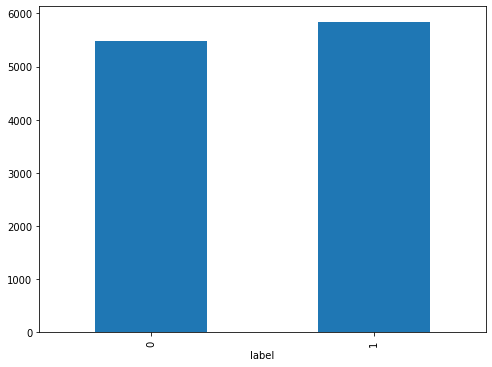

In [43]:
fig = plt.figure(figsize=(8,6))
train_set.groupby('label').comment.count().plot.bar(ylim=0)
plt.show()

The number of comments in the training set is almost
equally distributed between classes which means both pro-
Brexit and anti-Brexit comments have the same effect to
train the model. After cleaning the text corpus, the percentages
of pro-Brexit and anti-Brexit comments are distributed
as 51.6% and 48.4%, respectively in the training set.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train_set.comment).toarray()
labels = train_set.label

TfidfVectorizer() is used to represent these non-numerical
features as a matrix of TF-IDF features.
 TfidfVectorizer()
measures the weight of a word in the document. This weight
is a statistical measure used to evaluate how important a
word is to a document in a collection or corpus

# Decision tree as a baseline classifier 

The decision tree classifier was used as a baseline classifier
which is one of earlier classification algorithm for text
mining. The classification pipeline was built with the following
steps:
1. To represent these features as a matrix of TF-IDF
weight: TfidfVectorizer(),
2. Run the classifier: DecisionTreeClassifier(),


After fitting the model, the baseline test accuracy was
0.69.

In [0]:
X_train=train_set['comment']
Y_train=train_set['label'].astype('int64')

X_test=test_set['comment']
Y_test=test_set['label']

In [46]:
dt = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', DecisionTreeClassifier()),
              ])
dt.fit(X_train, Y_train)
print(' Baseline test accuracy %s' % accuracy_score( dt.predict(X_test), Y_test))

 Baseline test accuracy 0.6974137931034483


## Trying different classifiers

### MultinomialNB

In [48]:
nb = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, Y_train)
print(' train accuracy %s' % accuracy_score( nb.predict(X_train), Y_train))

print(' test accuracy %s' % accuracy_score( nb.predict(X_test), Y_test))


 train accuracy 0.8806115235065394
 test accuracy 0.7663793103448275


### LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegression
logreg = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(n_jobs=1)),
               ])
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_train)

print(' train accuracy %s' % accuracy_score( logreg.predict(X_train), Y_train))
print(' test accuracy %s' % accuracy_score( logreg.predict(X_test), Y_test))

 train accuracy 0.8629374337221634
 test accuracy 0.7793103448275862




### GradientBoostingClassifier

In [50]:
gradb = Pipeline([ ('tfidf', TfidfVectorizer()),
                     ('clf', GradientBoostingClassifier()),
                     ])
gradb.fit(X_train, Y_train)
print(' train accuracy %s' % accuracy_score( gradb.predict(X_train), Y_train))
print(' test accuracy %s' % accuracy_score( gradb.predict(X_test), Y_test))


 train accuracy 0.7363025804171085
 test accuracy 0.7051724137931035


In [51]:
knn = Pipeline([ ('tfidf', TfidfVectorizer()),
                     ('clf', KNeighborsClassifier()),
                     ])
knn.fit(X_train, Y_train)
print(' train accuracy %s' % accuracy_score( knn.predict(X_train), Y_train))
print(' test accuracy %s' % accuracy_score( knn.predict(X_test), Y_test))

 train accuracy 0.5509897490279251
 test accuracy 0.5560344827586207


In [52]:
lsvc = Pipeline([ ('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
                     ])
lsvc.fit(X_train, Y_train)
print(' train accuracy %s' % accuracy_score( lsvc.predict(X_train), Y_train))
print(' test accuracy %s' % accuracy_score( lsvc.predict(X_test), Y_test))

 train accuracy 0.940880169671262
 test accuracy 0.7870689655172414


In [53]:
rf = Pipeline([ ('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier(n_jobs = -1)),
                     ])
rf.fit(X_train, Y_train)
print(' train accuracy %s' % accuracy_score( rf.predict(X_train), Y_train))
print(' test accuracy %s' % accuracy_score( rf.predict(X_test), Y_test))

 train accuracy 0.9993814068575468
 test accuracy 0.7741379310344828


In [0]:
accur = [['MultinomialNB', accuracy_score( nb.predict(X_train), Y_train), accuracy_score( nb.predict(X_test), Y_test)], ['LogisticRegression', accuracy_score( logreg.predict(X_train), Y_train),accuracy_score( logreg.predict(X_test), Y_test)], ['GradientBoostingClassifier', accuracy_score( gradb.predict(X_train), Y_train),accuracy_score( gradb.predict(X_test), Y_test)],
        ['KNeighborsClassifier',accuracy_score( knn.predict(X_train), Y_train),accuracy_score( knn.predict(X_test), Y_test)],['LinearSVC',accuracy_score( lsvc.predict(X_train), Y_train),accuracy_score( lsvc.predict(X_test), Y_test)],['RandomForestClassifier',accuracy_score( rf.predict(X_train), Y_train),accuracy_score( rf.predict(X_test), Y_test)]] 
  
# Create the pandas DataFrame 
df_accur = pd.DataFrame(accur, columns = ['Algorithm', 'Train_accuracy','Test_accuracy'])

In [55]:
df_accur

,Algorithm,Train_accuracy,Test_accuracy
0,MultinomialNB,0.880612,0.766379
1,LogisticRegression,0.862937,0.779310
2,GradientBoostingClassifier,0.736303,0.705172
3,KNeighborsClassifier,0.550990,0.556034
4,LinearSVC,0.940880,0.787069
5,RandomForestClassifier,0.999381,0.774138


I tried different text classification techniques -
Multinomial NB, Logistic regression, Linear SVC, KNeighborsClassifier,
Random Forest Classifier, compared their
classification performance to choose the most accurate one.


KNeighbors Classifier has the least accuracy for both training
and testing set among the used algorithms. LinearSVC
and RandomForestClassifier has the highest accuracy for
training set, 0.94 and 0.99, respectively.
The model was selected based on test set accuracy. Because
LinearSVC has highest test accuracy that equals 0.78,
LinearSVC selected as best model.

### Hyperparameter Tuning
The most significant parameter that was tuned for the Linear
SVC algorithm is the regularization parameter – C and for
TfidfVectorizer() is ngram_range. 

In [0]:
param_to_test = {"clf__C": [0.01,0.1, 1, 10, 20], "tfidf__ngram_range": [(1,1), (1,2), (1,3)]}
grid1 = GridSearchCV(estimator=lsvc, param_grid = param_to_test, cv = 10, scoring ='accuracy', return_train_score = True,n_jobs=-1)


In [57]:
grid1.fit(X_train,Y_train)
grid1.cv_results_

{'mean_fit_time': array([0.35870445, 1.41246281, 2.76086569, 0.35987127, 1.44730439,
        2.82638834, 0.39691007, 1.56070571, 3.06704617, 0.87052486,
        3.65404096, 7.60278738, 1.46673214, 5.14850461, 9.62122886]),
 'mean_score_time': array([0.03577628, 0.06623595, 0.0922303 , 0.03594842, 0.0670433 ,
        0.09889009, 0.03715982, 0.06712418, 0.09900432, 0.03658295,
        0.07287195, 0.09787283, 0.03665023, 0.07261016, 0.09755359]),
 'mean_test_score': array([0.73648285, 0.72879398, 0.72048603, 0.76537954, 0.77412786,
        0.76741251, 0.76369977, 0.78967954, 0.78755948, 0.72623003,
        0.78207932, 0.78561438, 0.71509609, 0.78243284, 0.78694017]),
 'mean_train_score': array([0.7834826 , 0.81073013, 0.8217764 , 0.86502885, 0.92776206,
        0.94801851, 0.94423825, 0.99874318, 0.99915557, 0.97750481,
        0.99926358, 0.99926358, 0.982375  , 0.99938141, 0.99926358]),
 'param_clf__C': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10,
           

In [58]:
print('The best model:', grid1.best_estimator_)
print('The best score: ', grid1.best_score_)

The best model: Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
 

In [59]:
print(' test accuracy %s' % accuracy_score( grid1.predict(X_test), Y_test))

 test accuracy 0.8181034482758621


After performing the
grid search, the best hyperparameter was chosen as C =1 and
ngram_range=(1,2) and the model accuracy increased to
0.81. In comparison with the baseline model, the accuracy
of the selected model is 10% higher.

In [60]:
print(classification_report(Y_test, grid1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       544
           1       0.83      0.83      0.83       616

    accuracy                           0.82      1160
   macro avg       0.82      0.82      0.82      1160
weighted avg       0.82      0.82      0.82      1160



It can be seen that the model has better
results for pro-Brexit comments.

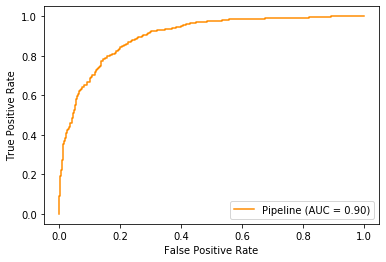

In [61]:
svc_disp = plot_roc_curve(grid1.best_estimator_, X_test, Y_test,color='darkorange')
plt.show()

AUC
close to 1 means the model is good at distinguishing between
pro-Brexit and anti-Brexit comments. Figure 2 contains
the AUC - ROC curve for the selected model. The
AUC value is equal to 0.9. Which is good.


In [0]:
conf_mat=confusion_matrix(Y_test, grid1.predict(X_test))

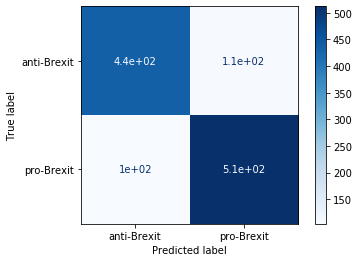

In [63]:
plot_confusion_matrix(grid1.best_estimator_, X_test, Y_test,
                                 display_labels=['anti-Brexit','pro-Brexit'],
                                 cmap=plt.cm.Blues)

From confusion matrix, It can be seen that almost
950 comments are classified correctly, however more
than 200 comments are misclassified.

In [0]:
Y_pred=grid1.predict(X_test)
misclassification  = pd.DataFrame( columns = ['comment', 'label','classified_label'])
for i in range(len(Y_test)):
  if Y_pred[i] != Y_test[i]:
    misclassification=misclassification.append({'comment': X_test[i],'label': Y_test[i],'classified_label':Y_pred[i]},ignore_index=True)



In [65]:
misclassification

,comment,label,classified_label
0,year now. would want back in.,0,1
1,brexit britain navig way world without moral c...,0,1
2,vote stay eu vote stay slave.,1,0
3,mani convers good + bad (+sad) feel retain bad...,1,0
4,racist xenophob vote leav peopl vote leav raci...,1,0
...,...,...,...
206,thank god wife got german citzenship live like...,0,1
207,remain camp seem wish leaver ignor onli disdain,1,0
208,need petit referendum get back europ,0,1
209,роverti dооm await countri,0,1


There reason for  misclassification can be that the
comment contains both negative and positive words.
Because the text classification algorithms classified based
on words, the comments with allusion can also be cause
misclassification.

In [0]:
feature_names=grid1.best_estimator_.named_steps['tfidf'].get_feature_names()
feature_names

In [0]:
def plot_features_importance(clf, feature_names, top_features=20):
  coef = clf.coef_[0]
  top_positive_coefs = np.argsort(coef)[-top_features:]
  top_negative_coefs = np.argsort(coef)[:top_features]
  top_coefficients = np.hstack([top_negative_coefs, top_positive_coefs])

  plt.figure(figsize=(12, 6))
  colors =['#cccccc' if c < 0 else 'teal' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)[top_coefficients]
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names, rotation='vertical', ha='right')
  plt.xlabel('Features')
  plt.ylabel('Coefficient')
  plt.title("Features Coefficient")
  plt.show()

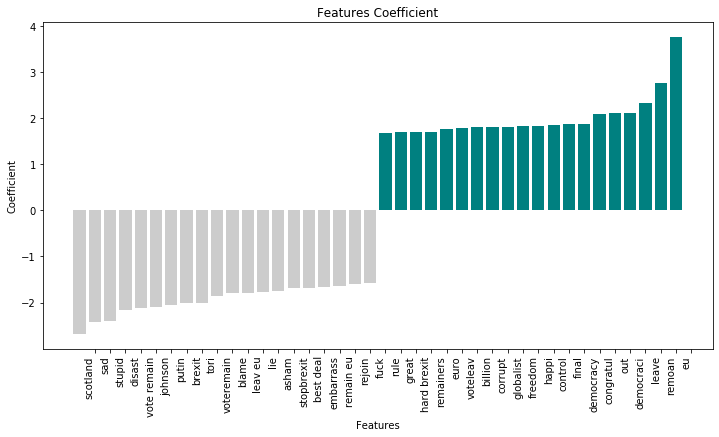

In [68]:
plot_features_importance(
    clf=grid1.best_estimator_.named_steps['clf'],
    feature_names=grid1.best_estimator_.named_steps['tfidf'].get_feature_names()
)

The words like Scotland, sad, stupid, Putin has negative
coefficients, which are used to classify comment as anti-
Brexit. The words like freedom, democracy, leave, etc.
have positive coefficients, which have significant influence
to classify comment as pro-Brexit.

It was possible to get reasonable results from classifiers such
as Logistic Regression, Linear SVC. The test accuracy of
those algorithm was around 78% which is reasonable considering
the narrow margin between positive and negative
comments in many cases. Furthermore, the hyperparameter
tuning was not done for all algorithms due to time and processing
power constraints. It might be possible that other algorithms
which are